In [ ]:
!pip install torch matplotlib numpy tqdm

In [ ]:
# download fashion-mnist dataset
!wget -q http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz
!wget -q http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz
!wget -q http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz
!wget -q http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz

In [ ]:
import torch
from torch import nn
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

Ankle boot


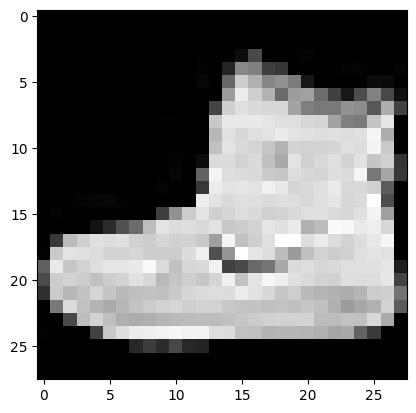

In [ ]:
# create Dataset from our training and testing data
from torch.utils.data import Dataset
import gzip

class FashionMNIST(Dataset):
    def __init__(self, root_dir, test=False):
        """
        Arguments:
            root_dir (string): Directory containing the data files.
            test (boolean, optional): Whether the test set should be used.
        """
        which = "train" if not test else "t10k"
        with gzip.open(root_dir + f'/{which}-labels-idx1-ubyte.gz', 'rb') as f:
            self.labels = np.frombuffer(f.read(), dtype=np.uint8, offset=8)
        with gzip.open(root_dir + f'/{which}-images-idx3-ubyte.gz', 'rb') as f:
            self.data = np.frombuffer(f.read(), dtype=np.uint8, offset=16).reshape(len(self.labels), 1, 28, 28)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        return self.data[idx].astype(np.float32), self.labels[idx]

train_set = FashionMNIST(root_dir='.', test=False)
test_set = FashionMNIST(root_dir='.', test=True)

labelMap = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

# show an example data point
img, label = train_set[0]
print(labelMap[label])
# displaying the first (and only) channel in the image
plt.imshow(img[0], cmap='gray')

In [ ]:
# create validation set
from torch.utils.data import random_split

train_set_size = int(len(train_set) * 0.9)
val_set_size = len(train_set) - train_set_size
train_set, val_set = random_split(train_set, [train_set_size, val_set_size])

In [ ]:
# create DataLoaders
from torch.utils.data import DataLoader

batch_size = 64

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

In [ ]:
for images, labels in train_loader:
  print(images.shape, labels.shape)
  break

torch.Size([64, 1, 28, 28]) torch.Size([64])


In [ ]:
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(1, 6, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(6, 16, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(16 * 4 * 4, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 10)
        )

    def forward(self, x):
        return self.layers(x)


net = LeNet()
print(net)

LeNet(
  (layers): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=256, out_features=120, bias=True)
    (8): ReLU()
    (9): Linear(in_features=120, out_features=84, bias=True)
    (10): ReLU()
    (11): Linear(in_features=84, out_features=10, bias=True)
  )
)


In [ ]:
for images, labels in train_loader:
  print(images.shape, labels.shape)
  outputs = net(images)
  print(outputs.shape)
  break

torch.Size([64, 1, 28, 28]) torch.Size([64])
torch.Size([64, 10])


In [ ]:
from tqdm.notebook import tqdm

def train(model, train_loader, val_loader, loss_fn, optimizer, epochs=10):
  accuracies = []
  test_accuracies = []
  try:
    for epoch in tqdm(range(epochs)):
      model.train()
      print(f"Epoch: {epoch}")
      total_loss = 0
      count = 0
      correct, total = 0, 0
      correct_test, total_test = 0, 0
      for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = net(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        count += 1
      print(f"Train Loss: {total_loss / count}")
      model.eval()
      with torch.no_grad():
        total_loss = 0
        count = 0
        for images, labels in val_loader:
          outputs = net(images)
          loss = loss_fn(outputs, labels)
          predicted = outputs.argmax(dim=1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
          total_loss += loss.item()
          count += 1
        print(f"Val Loss: {total_loss / count}")
        for images, labels in test_loader:
          outputs = net(images)
          predicted = outputs.argmax(dim=1)
          total_test += labels.size(0)
          correct_test += (predicted == labels).sum().item()
      accuracies.append(correct / total)
      print(f"Accuracy: {100 * correct / total}%")
      test_accuracies.append(correct_test / total_test)
    return accuracies, test_accuracies
  except KeyboardInterrupt:
    print("Exiting...")
    return accuracies, test_accuracies
  return

def test(model, test_loader):
  model.eval()
  correct = 0
  total = 0
  with torch.no_grad():
    for images, labels in test_loader:
      outputs = net(images)
      predicted = outputs.argmax(dim=1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  print(f"Accuracy: {100 * correct / total}%")

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
net_acc, net_test_acc = train(net, train_loader, val_loader, loss_fn, optimizer, epochs=10)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
Train Loss: 0.5548551511460853
Val Loss: 0.4236247713895554
Accuracy: 84.46666666666667%
Epoch: 1
Train Loss: 0.3717439678625614
Val Loss: 0.3873388261554089
Accuracy: 85.21666666666667%
Epoch: 2
Train Loss: 0.32832398263834667
Val Loss: 0.35223198000420913
Accuracy: 86.91666666666667%
Epoch: 3
Train Loss: 0.30283967959937325
Val Loss: 0.3606038779971447
Accuracy: 87.53333333333333%
Epoch: 4
Train Loss: 0.284301903946281
Val Loss: 0.33634193194039325
Accuracy: 87.93333333333334%
Epoch: 5
Train Loss: 0.26995442631120364
Val Loss: 0.3499509926806105
Accuracy: 87.0%
Epoch: 6
Train Loss: 0.2583617309805765
Val Loss: 0.32916486334610495
Accuracy: 88.11666666666666%
Epoch: 7
Train Loss: 0.24668939337928855
Val Loss: 0.31077801959311707
Accuracy: 88.71666666666667%
Epoch: 8
Train Loss: 0.23535914765891588
Val Loss: 0.32210734288426157
Accuracy: 88.71666666666667%
Epoch: 9
Train Loss: 0.22649398860985068
Val Loss: 0.31692489680457625
Accuracy: 89.2%


In [ ]:
test(net, test_loader)

Accuracy: 88.49%


In [ ]:
class LeNetDropout(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(1, 6, 5, padding=2),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            # nn.Dropout(0.2),
            nn.Conv2d(6, 16, 5, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            # nn.Dropout(0.2),
            nn.Flatten(),
            nn.Linear(16 * 4 * 4, 120),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(84, 10)
        )

    def forward(self, x):
        return self.layers(x)


net_dropout = LeNet()
print(net)

LeNet(
  (layers): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=256, out_features=120, bias=True)
    (8): ReLU()
    (9): Linear(in_features=120, out_features=84, bias=True)
    (10): ReLU()
    (11): Linear(in_features=84, out_features=10, bias=True)
  )
)


In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
net_dropout_accuracies, net_dropout_test_acc = train(net_dropout, train_loader, val_loader, loss_fn, optimizer, epochs=10)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
Train Loss: 0.2233228612276262
Val Loss: 0.32784078309827663
Accuracy: 88.45%
Epoch: 1
Train Loss: 0.21030691055960565
Val Loss: 0.3257079572278134
Accuracy: 89.05%
Epoch: 2
Train Loss: 0.20342447870009317
Val Loss: 0.3419429986400807
Accuracy: 89.05%
Epoch: 3
Train Loss: 0.1963920322560233
Val Loss: 0.3349592799836017
Accuracy: 88.61666666666666%
Epoch: 4
Train Loss: 0.18809144710018455
Val Loss: 0.34234196692705154
Accuracy: 88.55%
Epoch: 5
Train Loss: 0.18728350582245684
Val Loss: 0.3725834296263279
Accuracy: 88.48333333333333%
Epoch: 6
Train Loss: 0.17696804571808514
Val Loss: 0.3735737210892616
Accuracy: 88.65%
Epoch: 7
Train Loss: 0.1763511090649742
Val Loss: 0.36026940264917434
Accuracy: 88.75%
Epoch: 8
Train Loss: 0.17300595287939807
Val Loss: 0.3774208084065863
Accuracy: 88.73333333333333%
Epoch: 9
Train Loss: 0.1649026483147277
Val Loss: 0.3679341209378648
Accuracy: 88.83333333333333%


In [ ]:
test(net_dropout, test_loader)

Accuracy: 88.34%


In [ ]:
class LeNetBatchNorm(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(1, 6, 5, padding=2),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(6, 16, 5, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(16 * 4 * 4, 120),
            nn.BatchNorm2d(120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.BatchNorm2d(84),
            nn.ReLU(),
            nn.Linear(84, 10)
        )

    def forward(self, x):
        return self.layers(x)


net_batchnorm = LeNet()
print(net)

LeNet(
  (layers): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=256, out_features=120, bias=True)
    (8): ReLU()
    (9): Linear(in_features=120, out_features=84, bias=True)
    (10): ReLU()
    (11): Linear(in_features=84, out_features=10, bias=True)
  )
)


In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
net_batchnorm_accuracies, net_batchnorm_test_acc = train(net_batchnorm, train_loader, val_loader, loss_fn, optimizer, epochs=10)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
Train Loss: 0.16786486098225012
Val Loss: 0.40119293704628944
Accuracy: 88.11666666666666%
Epoch: 1
Train Loss: 0.15945131725177028
Val Loss: 0.4028500302674923
Accuracy: 88.06666666666666%
Epoch: 2
Train Loss: 0.15405811256424512
Val Loss: 0.4086374781550245
Accuracy: 88.73333333333333%
Epoch: 3
Train Loss: 0.15740770155396225
Val Loss: 0.41499509844691196
Accuracy: 88.8%
Epoch: 4
Train Loss: 0.14994218143285803
Val Loss: 0.4331118905956441
Accuracy: 88.55%
Epoch: 5
Train Loss: 0.14302637604378624
Val Loss: 0.439369206257323
Accuracy: 88.71666666666667%
Epoch: 6
Train Loss: 0.13499289800267295
Val Loss: 0.4411088466010195
Accuracy: 88.48333333333333%
Epoch: 7
Train Loss: 0.1408640994200421
Val Loss: 0.4461531404485094
Accuracy: 88.23333333333333%
Epoch: 8
Train Loss: 0.1399776447957196
Val Loss: 0.42002540057960974
Accuracy: 88.65%
Epoch: 9
Train Loss: 0.13228214002916175
Val Loss: 0.51083708538654
Accuracy: 88.25%


In [ ]:
htest(net_batchnorm, test_loader)

Accuracy: 88.33%


In [ ]:
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(1, 6, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(6, 16, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(16 * 4 * 4, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 10)
        )

    def forward(self, x):
        return self.layers(x)


net = LeNet()
print(net)

LeNet(
  (layers): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=256, out_features=120, bias=True)
    (8): ReLU()
    (9): Linear(in_features=120, out_features=84, bias=True)
    (10): ReLU()
    (11): Linear(in_features=84, out_features=10, bias=True)
  )
)


In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3, weight_decay=1e-4)
net_weight_decay_accuracies, net_weight_decay_test_acc = train(net, train_loader, val_loader, loss_fn, optimizer, epochs=10)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
Train Loss: 0.532703293743433
Val Loss: 0.37534836917481523
Accuracy: 86.2%
Epoch: 1
Train Loss: 0.3569106133080913
Val Loss: 0.34867607611925044
Accuracy: 87.55%
Epoch: 2
Train Loss: 0.31671449594129036
Val Loss: 0.3302046829398642
Accuracy: 87.98333333333333%
Epoch: 3
Train Loss: 0.29156070244962007
Val Loss: 0.33107178293644113
Accuracy: 87.51666666666667%
Epoch: 4
Train Loss: 0.27400110524271337
Val Loss: 0.3247864469885826
Accuracy: 87.88333333333334%
Epoch: 5
Train Loss: 0.2585070364848132
Val Loss: 0.3260583180854929
Accuracy: 88.15%
Epoch: 6
Train Loss: 0.24539927890197644
Val Loss: 0.31100894455262956
Accuracy: 88.76666666666667%
Epoch: 7
Train Loss: 0.23624862208785888
Val Loss: 0.30829748875917273
Accuracy: 88.61666666666666%
Epoch: 8
Train Loss: 0.22198262627973658
Val Loss: 0.33463945858022
Accuracy: 88.35%
Epoch: 9
Train Loss: 0.21551430562590534
Val Loss: 0.3355618734309014
Accuracy: 88.35%


In [ ]:
test(net, test_loader)

Accuracy: 88.37%


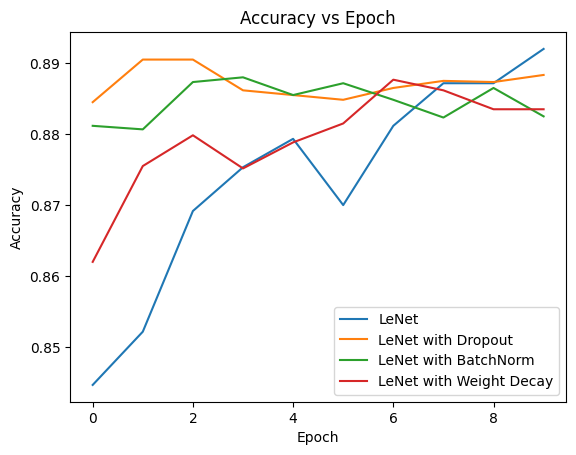

In [ ]:
import matplotlib.pyplot as plt
plt.plot(net_acc, label='LeNet')
plt.plot(net_dropout_accuracies, label='LeNet with Dropout')
plt.plot(net_batchnorm_accuracies, label='LeNet with BatchNorm')
plt.plot(net_weight_decay_accuracies, label='LeNet with Weight Decay')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
plt.legend()
plt.show()


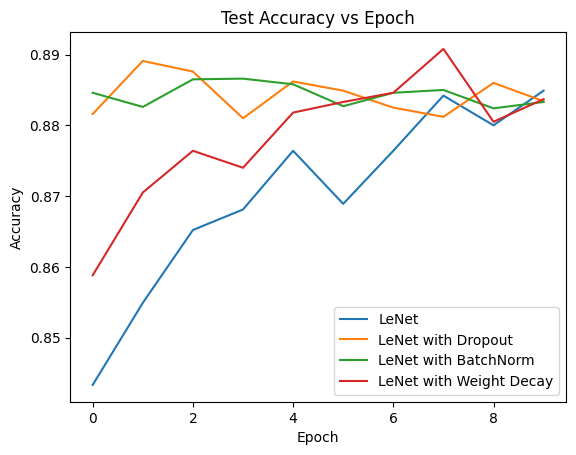

In [ ]:
import matplotlib.pyplot as plt
plt.plot(net_test_acc, label='LeNet')
plt.plot(net_dropout_test_acc, label='LeNet with Dropout')
plt.plot(net_batchnorm_test_acc, label='LeNet with BatchNorm')
plt.plot(net_weight_decay_test_acc, label='LeNet with Weight Decay')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy vs Epoch')
plt.legend()
plt.show()


In [ ]:
# prompt: print all accuracies

print(f"LeNet Accuracies: {net_acc}")
print(f"LeNet with Dropout Accuracies: {net_dropout_accuracies}")
print(f"LeNet with BatchNorm Accuracies: {net_batchnorm_accuracies}")
print(f"LeNet with Weight Decay Accuracies: {net_weight_decay_accuracies}")


LeNet Accuracies: [0.8446666666666667, 0.8521666666666666, 0.8691666666666666, 0.8753333333333333, 0.8793333333333333, 0.87, 0.8811666666666667, 0.8871666666666667, 0.8871666666666667, 0.892]
LeNet with Dropout Accuracies: [0.8845, 0.8905, 0.8905, 0.8861666666666667, 0.8855, 0.8848333333333334, 0.8865, 0.8875, 0.8873333333333333, 0.8883333333333333]
LeNet with BatchNorm Accuracies: [0.8811666666666667, 0.8806666666666667, 0.8873333333333333, 0.888, 0.8855, 0.8871666666666667, 0.8848333333333334, 0.8823333333333333, 0.8865, 0.8825]
LeNet with Weight Decay Accuracies: [0.862, 0.8755, 0.8798333333333334, 0.8751666666666666, 0.8788333333333334, 0.8815, 0.8876666666666667, 0.8861666666666667, 0.8835, 0.8835]
